# Music Machine Learning - Sampling


Faire juste le sampling par réjection.

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. Defining [sampling](#sampling) procedure with Monte-Carlo.
2. Motivating the use of [Markov chains](#markov) in sampling.
2. Implementing the [Gibbs sampling](#gibbs) algorithm.

We begin with the standard imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from helper_plot import hdr_plot_style
hdr_plot_style()

<a id="sampling"></a>
## Sampling

The main idea of sampling, is that we have a very complicated distribution, for which we do not know either the closed-form or its parameters. Although it is hard to find an adequate estimation of this distribution, we can try to solve simpler problems, by estimating _expected values_ of this distribution. To do so, we will define an _estimator_, for which we know that it will provide an accurate evaluation if we have a sufficient number of samples.


#### Example with $\pi$

A simple example to understand the underlying logic is that of trying to approximate $\pi$. We know that we have the following relations, which means that we can estimate $\pi$ as a form of expectation, by drawing _random samples_

$$
\begin{align}
\frac{\pi}{4} &= \mathbb{E}\left[ x^{2} + y^{2} \leq 1 \right] \\
&\approx \frac{1}{M} \sum_{s=1}^{M} \left[ x_{s}^{2} + y_{s}^{2} \leq 1 \right]
\end{align}
$$

with $x_{s},y_{s}\sim \mathcal{U}(0,1)$

3.162


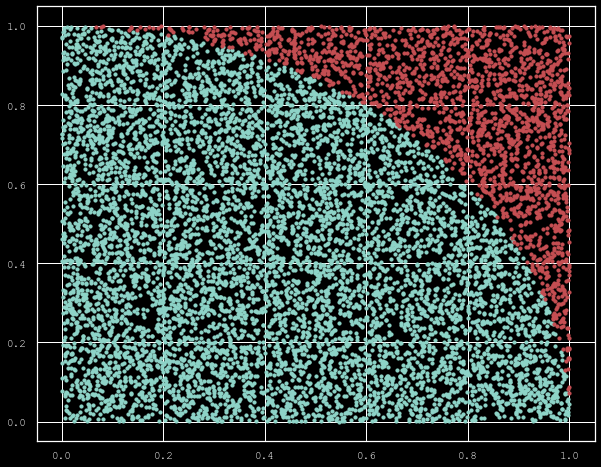

In [2]:
import random as r
import math as m
# Number of darts that land inside.
inside = 0
inside_pts = []
outside_pts = []
# Total number of darts to throw.
total = 10000
# Iterate for the number of darts.
for i in range(0, total):
    # Generate random x, y in [0, 1].
    x2 = r.random() ** 2
    y2 = r.random() ** 2
    # Increment if inside unit circle.
    if (x2 + y2) <= 1.0:
        inside += 1
        inside_pts.append([m.sqrt(x2), m.sqrt(y2)])
    else:
        outside_pts.append([m.sqrt(x2), m.sqrt(y2)])
# Compute estimator
pi = (float(inside) / total) * 4
print(pi)
# Plot the points
inside_pts = np.array(inside_pts)
outside_pts = np.array(outside_pts)
plt.figure(figsize=(10,8))
plt.scatter(inside_pts[:, 0], inside_pts[:, 1], s=10)
plt.scatter(outside_pts[:, 0], outside_pts[:, 1], s=10, c='r');

Advantages of Monte-Carlo
- Very simple to program
- Universally applicable to lots of problems
- Scalable to parallelization

Problems 
- Usually very slow
- Better solutions might exist

## Formal introduction

The goal of Monte-Carlo methods is to _estimate expected values by sampling_
So we can define
$$
\mathbb{E}_{p(x)} f(x) \approx \frac{1}{M} \sum_{s=1}^{M} f(x_{s})
$$
with $x_{s} \sim p(x)$. This has nice co-properties
- This is an _unbiased_ estimator
- Guarantees on the convergence

### Why estimate expected values ?

Remember the goal of full Bayesian inference
$$
\begin{align}
p(y \vert x, Y_{train}, X_{train}) &= \int p(y \vert x, w) p(w \vert y_{train}, x_{train}) dw \\
&= \mathbb{E}_{p(w\vert Y_{train},X_{train})} p(y \vert x, w)
\end{align}
$$
Here we can use sample to simplify the problem by _sampling_

The same situation applies for the M-step of the EM-algorithm
$$
\underset{\theta}{\max} \mathbb{E}_{q} \log p(\mathbf{x},\mathbf{t} \vert \theta)
$$

## Sampling from 1d distributions

We start from the simplest case, where we have a discrete 1-d distribution. Imagine we want to sample from a Gaussian, so we can use the central limit theorem
$$
z = \sum_{i=1}^{12} x_{i} - 6
$$
If we take $x_{i} \sim \mathcal{U}[0,1]$, then we have $p(z)\approx\mathcal{N}(0,1)$.
Of course this is a rather crude approximation, we can rather use a more refined process

Now imagine we have a more complex distribution like this

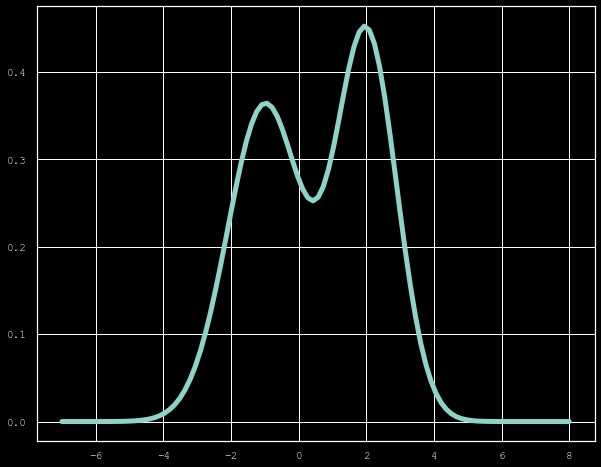

In [3]:
import math
import scipy.stats as stats
x = np.linspace(-7, 8, 100)
plt.figure(figsize=(10,8))
plt.plot(x, stats.norm.pdf(x, -1, 1.1) + stats.norm.pdf(x, 2, 0.9), linewidth = 5)

We can upper-bound our distribution by an approximation, for instance we have that
$$
\begin{align}
q(x) &= \mathcal{N}(1,3) \\
p(x) &\leq 2q(x)
\end{align}
$$
We use the constant $2$ as it is impossible to upper bound a distribution without multiplying it with a constant.

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.


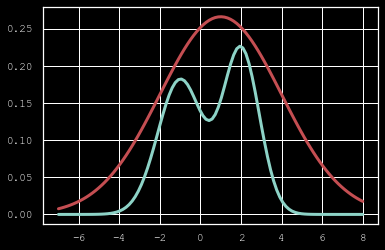

In [4]:
import math
import scipy.stats as stats
x = np.linspace(-7, 8, 100)
plt.plot(x, 0.5 * stats.norm.pdf(x, -1, 1.1) + 0.5 * stats.norm.pdf(x, 2, 0.9), linewidth=3)
plt.plot(x, stats.norm.pdf(x, 1, 3) * 2, c='r', linewidth=3)
plt.savefig('sampling_approx.pdf')

- Now note that we can sample from this approximation $q$ such that $\tilde{x}\sim q(x)$
- So how can we sample from our distribution $p$
- We now that we have a higher probability in $q$
- Therefore we need to *reject* some of the points
- The rule to reject should be probabilistic
    - Should be proportional to the height of the curves
    - So if we sample $\tilde{x}$ and take its coordinates $y \sim \mathcal{U}[0, 2q(\tilde{x})]$.
    - We can accept $\tilde{x}$ with probability $\frac{p(x)}{2q(x)}$ if $y\leq p(x)$
How much points do we accept ? Knowing that we have $p(x)\leq Mq(x)$, we accept $\frac{1}{M}$ points on average

Note that we can even use this _rejection sampling_ method if we know the distribution up to a normalization factor as
$$
\begin{align}
\frac{\hat{p}(x)}{Z} &\leq Mq(x) \\
\hat{p}(x) &\leq ZMq(x) \\
\end{align}
$$
For instance, we can define our distributions $p$ and $q$ as follows

In [5]:
import scipy.stats as st
def p(x):
    return st.norm.pdf(x, loc=30, scale=10) + st.norm.pdf(x, loc=80, scale=20)
def q(x):
    return st.norm.pdf(x, loc=50, scale=30)

Here, you can implement the algorithm for rejection sampling and test it out

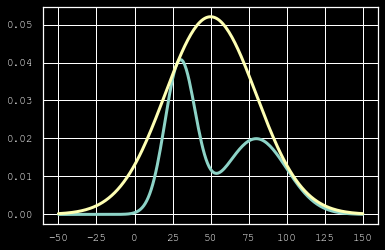

c:\Users\33689\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


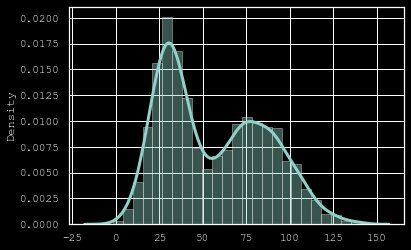

In [6]:
x = np.arange(-50, 151)
k = max(p(x) / q(x))

def rejection_sampling(iter=1000):
    samples = []
    
    ######################
    for i in range(iter):
        s = np.random.normal(loc=50, scale=30, size=1)
        y = np.random.uniform(0,k*q(s))
        
        if y <= p(s):
            samples.append(s)
    ######################
    
    return np.array(samples)

plt.plot(x, p(x))
plt.plot(x, k*q(x))
plt.show()
s = rejection_sampling(iter=10000)
sns.distplot(s);

Summary of rejection sampling
+ Pro : Works for most distributions
- Con : If $q$ and $p$ too different ($M$ large), rejects most points
- Con : $M$ is large for d-dimensional distributions

<a id="markov"></a>
## Markov chains

**Here explain the principle of Markov chains**

Using Markov chain for sampling
- We want to sample from p(x)
- Build a Markov chain that converges to $p(x)$
- Start from any $x^{0}$
- For $k=0,1,\cdots$
$$
x^{k+1}\sim T(x^{k}\rightarrow x^{k+1})
$$
- Eventually $x^{k}$ will look like samples from p(x)

### Do chains always converge ?

- Imagine a binary distribution
- Will never converge
- We need chains that do converge

**Definition** : A distribution $\pi$ is called _stationary_ if
$$
\pi(x')=\sum_{x} T(x\rightarrow x') \pi(x)
$$

**Theorem** : If $T(x\rightarrow x') > 0$ for all $x, x'$, then there exists a unique $\pi$ such that
$$
\pi(x')=\sum_{x} T(x\rightarrow x') \pi(x)
$$
And the Markov chain converges to $\pi$ from any starting point.

## Gibbs sampling

One of the easiest method to construct Markov chains to sample from a distribution. Say we have a 3-d distribution that we know up to norrmalization.
$$
p(x_{1}, x_{2}, x_{3}) = \frac{\hat{p}(x_{1}, x_{2}, x_{3})}{Z}
$$
The method of Gibbs sampling starts with $(x^{0}_{1}, x^{0}_{2}, x^{0}_{3})$ that we can set to $(0,0,0)$ for instance.

Then we are going to sample each dimension at a time by sampling from the conditional
$$
\begin{align}
x^{1}_{1} \sim &p(x_{1} \vert x_{2} = x^{0}_{2}, x_{3} = x^{0}_{3}) \\
&= \frac{\hat{p}(x_{1}, x^{0}_{2}, x^{0}_{3})}{Z}
\end{align}
$$
Then we reapply the same idea for the next dimensions.
$$
\begin{align}
x^{1}_{2} &\sim p(x_{2} \vert x_{1} = x^{1}_{1}, x_{3} = x^{0}_{3}) \\
x^{1}_{3} &\sim p(x_{3} \vert x_{1} = x^{1}_{1}, x_{2} = x^{1}_{2}) \\
\end{align}
$$
Note that in this case, we cannot parallelize these sampling steps.

We can prove that Gibbs sampling indeed converges to the desired distribution $p$. So we want to prove
$$
p(x',y',z') = \sum_{x,y,z} q(x,y,z\rightarrow x',y',z') p(x,y,z)
$$

Pros :
- Reduce multidimensional sampling to sequence of 1d sampling
- A few lines of code
Cons :
- Highly correlated samples
- Slow convergence (mixing)
- Cannot be parallelized

## Metropolis-Hastings

- Sometimes Gibbs samples are too correlated
- Idea of MH is to apply rejection sampling to Markov chains
Let's start with any Markov chain $Q$ 
- Sample $x'$ from a _wrong_ $Q(x^{k}\rightarrow x')$ for $k=1,2,\cdots$
- Use a critic to accept proposal $x'$ with probabiility $A(x^{k}\rightarrow x')$
- Otherwise stay at $x^{k}$, such that $x^{k+1}=x^{k}$
So overall, the scheme works as
$$
\begin{align}
T(x\leftarrow x') &= Q(x\leftarrow x')A(x\leftarrow x'), \forall x\neq x'
T(x\leftarrow x) &= Q(x\leftarrow x)A(x\leftarrow x)\\
&+ \sum_{x\neq x'} Q(x\leftarrow x')(1 - A(x\leftarrow x'))
\end{align}
$$

How to choose A : $\pi(x')=\sum_{x} T(x\rightarrow x') \pi(x)$, we need to introduce the _detailed balance_ condition

<a id="gibbs"></a>
## [Bonus] Gibbs Sampling implementation

The Gibbs sampler is the simplest and most prevalent MCMC algorithm. If a posterior has $k$ parameters to be estimated, we may condition each parameter on current values of the other $k-1$ parameters, and sample from the resultant distributional form (usually easier), and repeat this operation on the other parameters in turn. This procedure generates samples from the posterior distribution. Note that we have now combined Markov chains (conditional independence) and Monte Carlo techniques (estimation by simulation) to yield Markov chain Monte Carlo.

Here is a stereotypical Gibbs sampling algorithm:

1.  Choose starting values for states (parameters):
    ${\bf \theta} = [\theta_1^{(0)},\theta_2^{(0)},\ldots,\theta_k^{(0)}]$.

2.  Initialize counter $j=1$.

3.  Draw the following values from each of the $k$ conditional
    distributions:

    $$\begin{aligned}
    \theta_1^{(j)} &\sim \pi(\theta_1 | \theta_2^{(j-1)},\theta_3^{(j-1)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
    \theta_2^{(j)} &\sim \pi(\theta_2 | \theta_1^{(j)},\theta_3^{(j-1)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
    \theta_3^{(j)} &\sim \pi(\theta_3 | \theta_1^{(j)},\theta_2^{(j)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
    \vdots \\
    \theta_{k-1}^{(j)} &\sim \pi(\theta_{k-1} | \theta_1^{(j)},\theta_2^{(j)},\ldots,\theta_{k-2}^{(j)},\theta_k^{(j-1)}) \\
    \theta_k^{(j)} &\sim \pi(\theta_k | \theta_1^{(j)},\theta_2^{(j)},\theta_4^{(j)},\ldots,\theta_{k-2}^{(j)},\theta_{k-1}^{(j)})\end{aligned}$$

4.  Increment $j$ and repeat until convergence occurs.

As we can see from the algorithm, each distribution is conditioned on the last iteration of its chain values, constituting a Markov chain as advertised. The Gibbs sampler has all of the important properties outlined in the previous section: it is aperiodic, homogeneous and ergodic. Once the sampler converges, all subsequent samples are from the target distribution. This convergence occurs at a geometric rate.

#### Example: Inferring patterns in UK coal mining disasters

Let's try to model a more interesting example, a time series of recorded coal mining 
disasters in the UK from 1851 to 1962.

Occurrences of disasters in the time series is thought to be derived from a 
Poisson process with a large rate parameter in the early part of the time 
series, and from one with a smaller rate in the later part. We are interested 
in locating the change point in the series, which perhaps is related to changes 
in mining safety regulations.

In [7]:
disasters_array = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

n_count_data = len(disasters_array)

We are going to use Poisson random variables for this type of count data. Denoting year $i$'s accident count by $y_i$, 

$$y_i \sim \text{Poisson}(\lambda).$$

For those unfamiliar, Poisson random variables look like this:

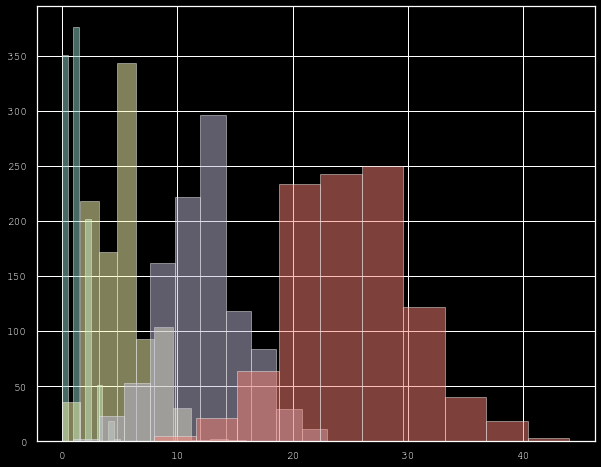

In [8]:
plt.figure(figsize=(10, 8))
for l in [1, 5, 12, 25]:
    plt.hist(np.random.poisson(l, 1000), alpha=0.5)

The modeling problem is about estimating the values of the $\lambda$ parameters. Looking at the time series above, it appears that the rate declines over time.

A **changepoint model** identifies a point (here, a year) after which the parameter $\lambda$ drops to a lower value. Let us call this point in time $\tau$. So we are estimating two $\lambda$ parameters:
$\lambda = \lambda_1$ if $t \lt \tau$ and $\lambda = \lambda_2$ if $t \geq \tau$.

We need to assign prior probabilities to both $\{\lambda_1, \lambda_2\}$. The gamma distribution not only provides a continuous density function for positive numbers, but it is also *conjugate* with the Poisson sampling distribution. 

In [9]:
lambda1_lambda2 = [(0.1, 100), (1, 100), (1, 10), (10, 10)]

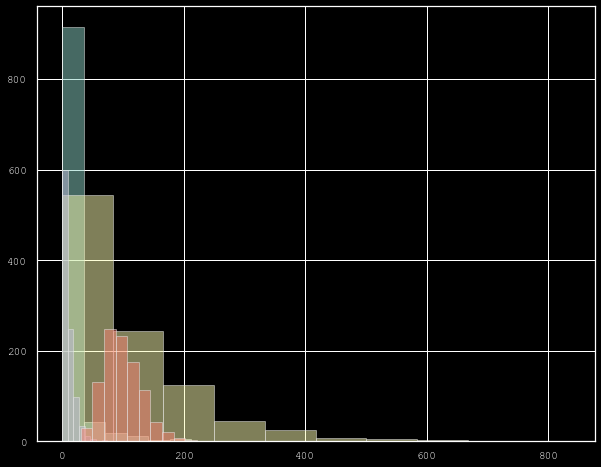

In [10]:
plt.figure(figsize=(10, 8))
for p in lambda1_lambda2:
    plt.hist(np.random.gamma(*p, size=1000), alpha=0.5)

We will specify suitably vague hyperparameters $\alpha$ and $\beta$ for both priors:

\begin{align}
\lambda_1 &\sim \text{Gamma}(1, 10), \\
\lambda_2 &\sim \text{Gamma}(1, 10).
\end{align}

Since we do not have any intuition about the location of the changepoint (unless we visualize the data), we will assign a discrete uniform prior over the entire observation period [1851, 1962]:

\begin{align}
&\tau \sim \text{DiscreteUniform(1851, 1962)}\\
&\Rightarrow P(\tau = k) = \frac{1}{111}.
\end{align}

### Implementing Gibbs sampling

We are interested in estimating the joint posterior of $\lambda_1, \lambda_2$ and $\tau$ given the array of annnual disaster counts $\mathbf{y}$. This gives:

$$
 P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) \propto P(\mathbf{y} | \lambda_1, \lambda_2, \tau ) P(\lambda_1, \lambda_2, \tau) 
$$

To employ Gibbs sampling, we need to factor the joint posterior into the product of conditional expressions:

$$
 P(\lambda_1, \lambda_2, \tau | \mathbf{y}) \propto P(y_{t \lt \tau} | \lambda_1, \tau) P(y_{t \geq \tau} | \lambda_2, \tau) P(\lambda_1) P(\lambda_2) P(\tau)
$$

which we have specified as:

$$\begin{aligned}
P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) &\propto \left[\prod_{t=1851}^{\tau} \text{Poi}(y_t|\lambda_1) \prod_{t=\tau+1}^{1962} \text{Poi}(y_t|\lambda_2) \right] \text{Gamma}(\lambda_1|\alpha,\beta) \text{Gamma}(\lambda_2|\alpha, \beta) \frac{1}{111} \\
&\propto \left[\prod_{t=1851}^{\tau} e^{-\lambda_1}\lambda_1^{y_t} \prod_{t=\tau+1}^{1962} e^{-\lambda_2} \lambda_2^{y_t} \right] \lambda_1^{\alpha-1} e^{-\beta\lambda_1} \lambda_2^{\alpha-1} e^{-\beta\lambda_2} \\
&\propto \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}
\end{aligned}$$

So, the full conditionals are known, and critically for Gibbs, can easily be sampled from.

$$\lambda_1 \sim \text{Gamma}(\sum_{t=1851}^{\tau} y_t +\alpha, \tau+\beta)$$
$$\lambda_2 \sim \text{Gamma}(\sum_{t=\tau+1}^{1962} y_i + \alpha, 1962-\tau+\beta)$$
$$\tau \sim \text{Categorical}\left( \frac{\lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}}{\sum_{k=1851}^{1962} \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}} \right)$$

Implementing this in Python requires random number generators for both the gamma and discrete uniform distributions. We can leverage NumPy for this:

In [11]:
# Function to draw random gamma variate
rgamma = np.random.gamma

def rcategorical(probs, n=None):
    # Function to draw random categorical variate
    return np.array(probs).cumsum().searchsorted(np.random.sample(n))

Next, in order to generate probabilities for the conditional posterior of $\tau$, we need the kernel of the gamma density:

\\[\lambda^{\alpha-1} e^{-\beta \lambda}\\]

In [12]:
dgamma = lambda lam, a, b: lam**(a - 1) * np.exp(-b * lam)

Diffuse hyperpriors for the gamma priors on $\{\lambda_1, \lambda_2\}$:

In [13]:
alpha, beta = 1., 10

For computational efficiency, it is best to pre-allocate memory to store the sampled values. We need 3 arrays, each with length equal to the number of iterations we plan to run:

In [14]:
# Specify number of iterations
n_iterations = 1000
# Initialize trace of samples
lambda1, lambda2, tau = np.empty((3, n_iterations + 1))

The penultimate step initializes the model paramters to arbitrary values:

In [15]:
lambda1[0] = 6
lambda2[0] = 2
tau[0] = 50

Now we can run the Gibbs sampler.

In [16]:
# Sample from conditionals
for i in range(n_iterations):

    ######################
    # YOUR CODE GOES HERE
    ######################
    

IndentationError: expected an indented block (<ipython-input-16-97387621d9b4>, line 7)

Plotting the trace and histogram of the samples reveals the marginal posteriors of each parameter in the model.

(array([ 25., 114., 509., 142., 197.,  10.,   1.,   0.,   2.,   1.]),
 array([34. , 36.9, 39.8, 42.7, 45.6, 48.5, 51.4, 54.3, 57.2, 60.1, 63. ]),
 <a list of 10 Patch objects>)

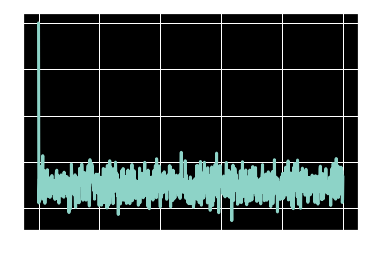

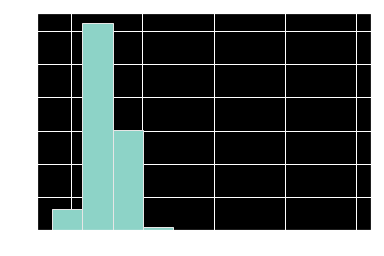

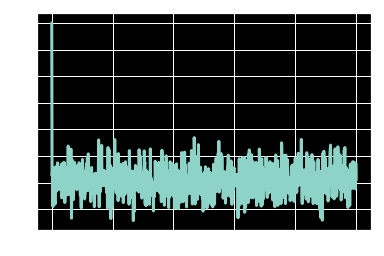

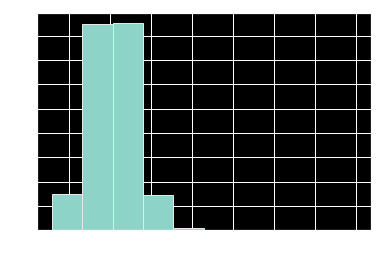

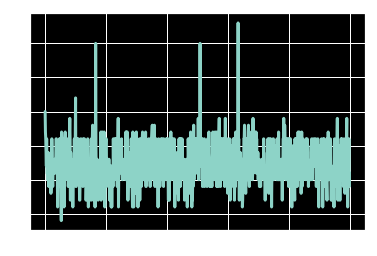

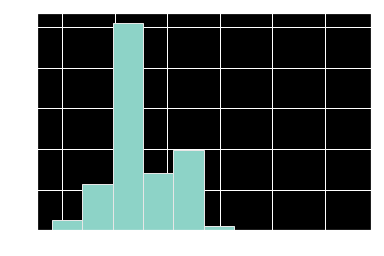

In [ ]:
plt.figure()
plt.plot(lambda1)
plt.figure()
plt.hist(lambda1)
plt.figure()
plt.plot(lambda2)
plt.figure()
plt.hist(lambda2)
plt.figure()
plt.plot(tau)
plt.figure()
plt.hist(tau)